## Introduction to the SAMPLED BASED DIAGONALIZATION

In [20]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

In [49]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'


In [60]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [-1.82959117e-19]
dimension= 640


#### Select the samples

In [76]:
prob=np.conjugate(psi0[:,0])*psi0[:,0]
prob_nozero=prob[prob<10**-25].copy()/np.sum(prob[prob<10**-25].copy())
nozero_index=np.arange(prob.shape[0])[prob<10**-25]
print(prob_nozero.shape)

(28,)


In [77]:

n_instances=20
bins=int(0.1*NSMHamiltonian.hamiltonian.shape[0])
print(bins)
selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances,replace=False,p=prob)

effective_hamiltonian=lil_matrix((n_instances,n_instances))

for a,idx_a in enumerate(selection):
    for b,idx_b in enumerate(selection):
        effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]


effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')

print(effective_egs)


64
[-25.72651428]


[1.55474606e-33 1.24078690e-32 4.64907086e-32 3.06132850e-32
 5.91201618e-35 2.74193715e-06 4.39629585e-07 9.40784502e-06
 1.84226446e-33 2.82866525e-07 8.48767069e-07 8.48767069e-07
 9.40784502e-06 8.57183269e-06 2.84754288e-06 4.24216944e-32
 2.87634067e-31 2.82866525e-07 6.22902714e-33 4.39629585e-07
 9.25236822e-06 9.04575696e-32 7.50221757e-32 3.14620336e-07
 4.27131432e-06 4.27131432e-06 1.35135605e-33 2.68399067e-31
 3.78148344e-32 3.85910445e-32 3.14620336e-07 4.27131432e-06
 4.27131432e-06 1.21377096e-32 4.39629585e-07 9.25236822e-06
 2.82866525e-07 8.48767069e-07 2.82866525e-07 3.61920069e-32
 9.40784502e-06 8.48767069e-07 8.57183269e-06 2.84754288e-06
 2.27690635e-34 2.74193715e-06 9.40784502e-06 4.39629585e-07
 2.50333871e-32 3.55670945e-31 6.19267216e-32 2.41904076e-31
 3.84906874e-32 5.11300747e-32 5.46680926e-32 7.29369830e-32
 3.14620336e-07 1.12562102e-31 8.57183269e-06 9.25236822e-06
 9.25236822e-06 8.57183269e-06 3.14620336e-07 6.43836146e-32
 2.84754288e-06 4.271314

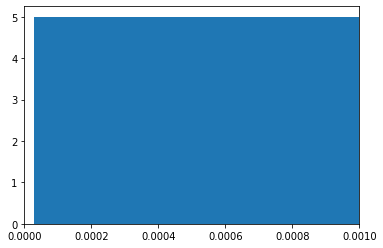

28
[7.51755850e-04 5.99949301e-03 2.24793380e-02 1.48022347e-02
 2.85859722e-05 8.90777679e-04 2.05118751e-02 1.39077756e-01
 3.01187938e-03 4.37383371e-02 3.62749654e-02 6.53412057e-04
 1.29777187e-01 1.82843513e-02 1.86596668e-02 5.86886468e-03
 1.74996764e-02 1.10093713e-04 1.21042244e-02 1.71975168e-01
 2.99430091e-02 1.16966242e-01 1.86111419e-02 2.47225794e-02
 2.64332932e-02 3.52667263e-02 5.44263920e-02 3.11309739e-02]
[2.85859722e-05 2.71525131e-03 5.40191665e-03 8.08858199e-03
 1.07752473e-02 1.34619127e-02 1.61485780e-02 1.88352433e-02
 2.15219087e-02 2.42085740e-02 2.68952394e-02 2.95819047e-02
 3.22685700e-02 3.49552354e-02 3.76419007e-02 4.03285661e-02
 4.30152314e-02 4.57018967e-02 4.83885621e-02 5.10752274e-02
 5.37618927e-02 5.64485581e-02 5.91352234e-02 6.18218888e-02
 6.45085541e-02 6.71952194e-02 6.98818848e-02 7.25685501e-02
 7.52552155e-02 7.79418808e-02 8.06285461e-02 8.33152115e-02
 8.60018768e-02 8.86885421e-02 9.13752075e-02 9.40618728e-02
 9.67485382e-02 9.94

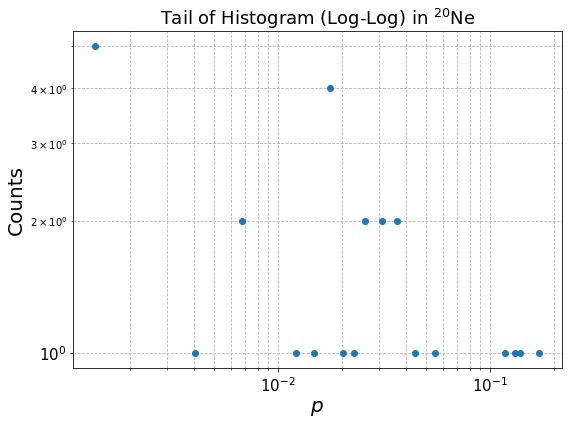

In [78]:
print(prob[prob<10**-5])

plt.hist(prob_nozero,bins=bins)
plt.xlim([0,10**-3])
plt.show()

# Compute histogram (don't plot yet)
counts, bin_edges = np.histogram(prob_nozero, bins=bins,density=False)
print(np.sum(counts))
print(prob_nozero)
print(bin_edges)

# Bin centers (x-axis)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Filter out zero counts to avoid log(0)
nonzero = counts > 0
counts = counts[nonzero]


bin_centers = bin_centers[nonzero]
bin_widths = np.diff(bin_edges)

print(bin_centers)

pdf = counts #/ (np.sum(counts))

# Plot in log-log scale
plt.figure(figsize=(8,6))
plt.loglog(bin_centers, pdf, marker='o', linestyle='none')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.title(r"Tail of Histogram (Log-Log) in "+title, fontsize=18)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [ ]:
e_values=[]
errors=[]
nbatches=100
for i in range(pdf.shape[0]):
    n_instances=np.sum(counts[-i-1:])
    print(n_instances)
    e_ave=0.
    for r in range(nbatches):
        
        selection=np.random.choice(nozero_index,size=n_instances,replace=False,p=prob_nozero)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        #print(effective_hamiltonian.shape)
        if effective_hamiltonian.shape[0]==1:
            effective_egs=NSMHamiltonian.hamiltonian.tocsr()[selection,selection][0,0]

        else:
            effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
            effective_egs=effective_egs[0]



        e_ave+=effective_egs

    e_ave=e_ave/nbatches
    print(e_ave)
    error=np.abs(e_ave-egs[0])/np.abs(egs[0])
    errors.append(error)
    e_values.append(e_ave)


1
-21.14909755714286
2
-24.51178092217905
3
-25.755101838029148
4
-26.511031877591275
5
-27.557580075357677
6
-27.697214052284608
8
-28.662472709719253
10
-28.947273052114575
12
-29.431475240492706
13
-29.480830961824978
14
-29.698559394783533
18
-30.051132830532538
19
-30.117803645590897
20
-30.165648231814988
22
-30.307370046469817
23
-30.44959664035192
28
-30.580402490738667


In [65]:


errors.reverse()
e_values.reverse()

errors=np.asarray(errors)
e_values=np.asarray(e_values)


[0.25780663 0.2699189  0.26683908 0.27075182 0.27548701 0.27257292
 0.28308947 0.28486373 0.29154126 0.30507849 0.30673275 0.32524814
 0.34473135 0.36479915 0.39464672 0.41382341 0.48753266]


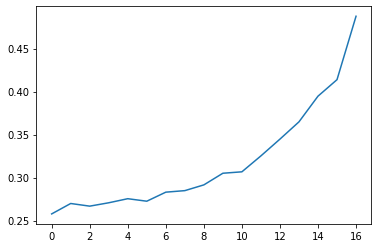

In [66]:

print(errors)
plt.plot(errors+10**-5)

plt.show()

-10.017185927392044
Fitted power law: y ≈ 0.000045 * x^(-1.633)
R² = 0.9152


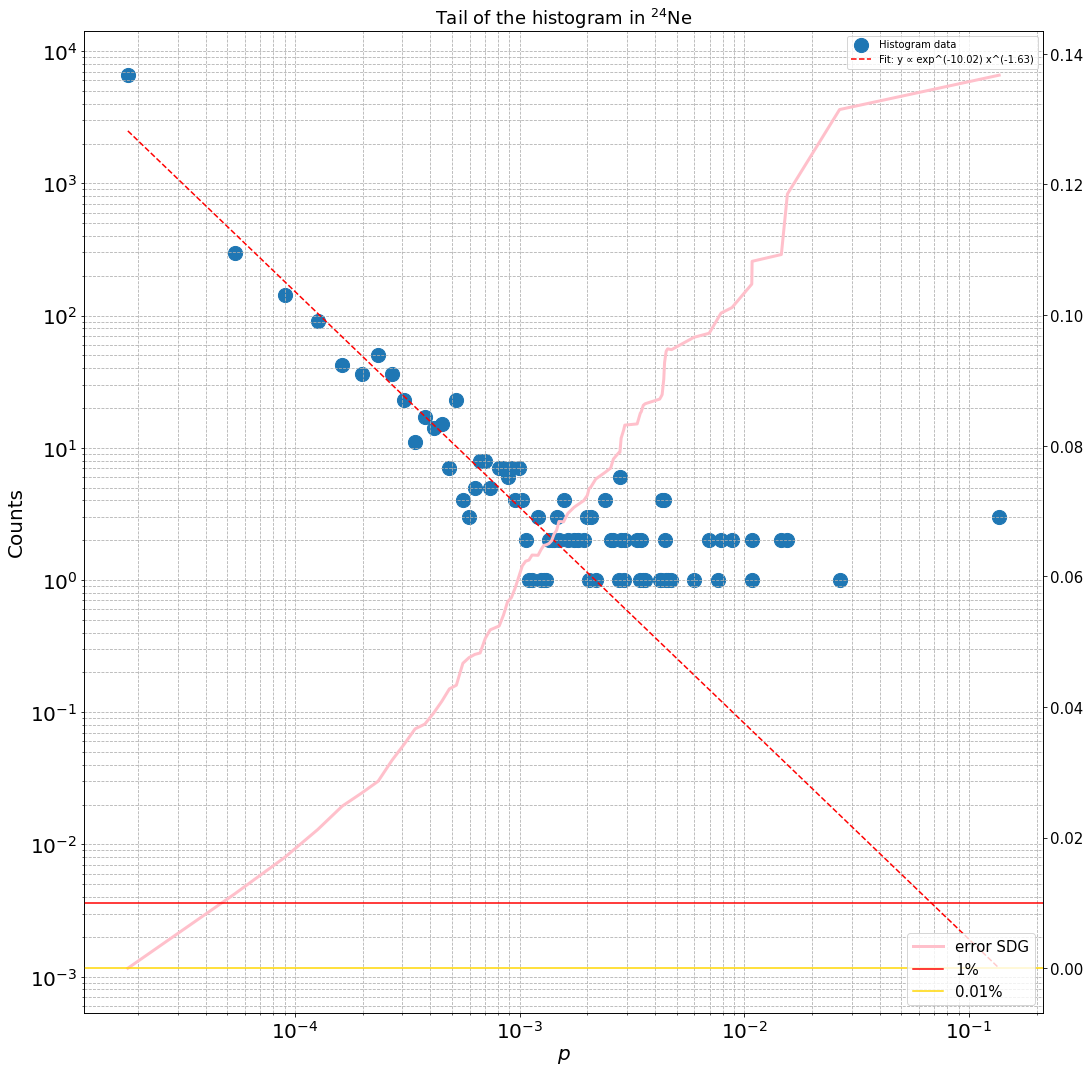

In [13]:
from scipy import stats
mask = counts > 0
x = bin_centers[mask]
y = counts[mask]

# Take logs
logx = np.log(x[x<10**-3])
logy = np.log(y[x<10**-3])

# Fit linear regression in log-log space
slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

# Extract power-law parameters
b = -slope
a = np.exp(intercept)
print(intercept)
print(f"Fitted power law: y ≈ {a:.6f} * x^(-{b:.3f})")
print(f"R² = {r_value**2:.4f}")

# Plot
fig,ax=plt.subplots(figsize=(15,15))

ax_twin=ax.twinx()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r"Tail of the histogram in "+title, fontsize=18)
ax.scatter(x, y,  label='Histogram data',s=200)
ax.loglog(x, a * x**(-b), 'r--', label=f'Fit: y ∝ exp^({np.log(a):.2f}) x^(-{b:.2f})')
ax.set_xlabel(r'$p$', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(labelsize=20)
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
ax_twin.plot(x,errors,color='pink',linewidth=3,linestyle='-',label='error SDG')
ax_twin.set_xlabel('relative error(SDG)',fontsize=20)

ax_twin.tick_params(labelsize=15)
ax_twin.axhline(y=0.01,label='1%',color='red')
ax_twin.axhline(y=0.0001,label='0.01%',color='gold')

ax_twin.legend(fontsize=15,loc='lower right')
plt.show()

#### Build-up an algorithm to save the number of instances with a fixed accuracy

Hyperparameters

In [ ]:
nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6),(10,8)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si',r'$^{32}$Ar']

history={}
errors=[]
n_instances_max=[]

for r,title in enumerate(titles):
    print('title=',title)
    nparticles_a=nparts[r][0]
    nparticles_b=nparts[r][1]
    
    history[nparts[r]]=[]
    
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

    print(egs)

    print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
    #print('j_value=',J2Class.j_value(psi0))
    print('dimension=',NSMHamiltonian.hamiltonian.shape[0])
    
    prob=np.conjugate(psi0[:,0])*psi0[:,0]
    
    n_instances=np.arange(2,prob.shape[0])
    
    error=1000
    i=0
    while(error> 10**-3):
        selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances[i],replace=False,p=prob)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        
        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        error=np.abs(effective_egs[0]-egs[0])/np.abs(egs[0])
        history[nparts[r]].append(error)
        
        i+=1
    
    n_instances_max.append(i)
    errors.append(error)
    print('\n')
    print(n_instances[i])
    print('error=',np.abs(effective_egs[0]-egs[0])/np.abs(egs[0]),'\n')     
    
    

#### Analysis of the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data=np.load('data/samplebaseddiagonalization_data/run_1%.npz')

errors=data['errors']
titles=data['titles']
history=data['history']
n_instances=data['n_instances']
dimensions=data['dimensions']

print(titles)
# 0 5 9 12
selection=[0,5,9,12]
print(titles[selection])

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell',fontsize=30)
plt.ylabel('n instances',fontsize=30)
plt.bar(np.arange(n_instances.shape[0]),dimensions)
plt.bar(np.arange(n_instances.shape[0]),n_instances)
#plt.semilogy()
plt.xticks(np.arange(n_instances.shape[0]),titles[:n_instances.shape[0]])
#plt.text(x=1,y=80000,s=r'$H=\sum_a e_a c^{+}_a c_a +\frac{1}{4}\sum_{abcd} v_{abdc} c^{+}_a c^{+}_b c_c c_d$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell (1% accuracy energy)',fontsize=30)
plt.ylabel(r'$N_s$',fontsize=30)
plt.xlabel(r'$\dim$',fontsize=30)

plt.scatter(dimensions,dimensions)
plt.plot(dimensions,dimensions)
plt.scatter(dimensions,n_instances)
plt.loglog()

plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.scatter(n_instances,dimensions)
plt.loglog()
plt.show()

from scipy import stats

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming these are your data
# dimensions = ...
# n_instances = ...

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")

# Plot original data and the fitted curve
plt.figure(figsize=(8,6))
plt.scatter(dimensions, n_instances, label='Data', color='blue')

# Create smooth line for fitted curve
x_fit = np.linspace(min(dimensions), max(dimensions), 200)
y_fit = a * x_fit**b
plt.plot(x_fit, y_fit, label=f'Fit: y ≈ {a:.2f} * x^{b:.2f}', color='red', linestyle='--')

# Log scales
plt.xscale('log')
plt.yscale('log')

# Labels
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
